In [1]:
import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
from matplotlib import pyplot as plt
from simulation_utils import EmbedInU,run_simp_layer_flow_example, SimulateBlock,EstimatePolarization


In [2]:
#Auxiliary function to perform the apodization of FID
def sqcosbell_2d_apod(fid_2d):
    fid_2d[0,:] = fid_2d[0,:]/2
    fid_2d[:,0] = fid_2d[:,0]/2
    x = np.linspace(0,np.pi/2,fid_2d.shape[0])
    y = np.linspace(0,np.pi/2,fid_2d.shape[1])

    decay_col = np.square(np.cos(x))
    decay_row = np.square(np.cos(y))

    return fid_2d*np.outer(decay_col,decay_row)


In [3]:
###Loading the generator of evolution...
loadMat = spio.loadmat('./data/DFG.mat',squeeze_me=True)

AuxMats = spio.loadmat('./data/DFG_NOESYmatrices.mat',squeeze_me=True)

Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()
t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

###Dynamical evolution for calculation of 2D spectra...
##TODO: we can simply modify the script to incorporate 1) retrieval of synthesized circuits,
#and 2) the already-developed circuit simulator

Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)

Dim = Ham.shape[0]

rho0 = np.array(AuxMats['rho0'].toarray())
rho0 = rho0.flatten()
coil = AuxMats['coil']


tmix = 0.5
dt1 = 1.1561e-04
dt2 = 1.1561e-04

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 1024

##Definition of pulses in the experiment...
#This also depends on the definition of the basis....
Lx = AuxMats['Lx'].toarray()
Ly = AuxMats['Ly'].toarray()

Lnet = Ham+1j*R #TODO: In the matlab script we have an additional contribution K
L_dt1 = expm(-1j*Lnet*dt1)
L_dt2 = expm(-1j*Lnet*dt2)
pulse_mix = expm(-1j*Lnet*tmix)


pulse_90x = expm(-1j*Lx*np.pi/2)
pulse_90y = expm(-1j*Ly*np.pi/2)
pulse_90mx = expm(1j*Lx*np.pi/2)
pulse_90my = expm(1j*Ly*np.pi/2)


FID_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
FID_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
FID_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
FID_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

#First 90x pulse:
rho_t = np.copy(rho0)
rho_t = np.dot(pulse_90x,rho_t)

In [4]:
rho_stack = []
rho_stack.append(rho_t)

rho_temp = np.copy(rho_t)
for i in range(1,Tpts1):
    rho_temp = np.dot(L_dt1,rho_temp)
    rho_stack.append(rho_temp)


rho_stack1_1 = []
rho_stack1_2 = []
rho_stack1_3 = []
rho_stack1_4 = []

for i in range(Tpts1):
    rho_stack1_1.append(pulse_90y@pulse_mix@pulse_90x@rho_stack[i])
    rho_stack1_2.append(pulse_90y@pulse_mix@pulse_90y@rho_stack[i])
    rho_stack1_3.append(pulse_90y@pulse_mix@pulse_90mx@rho_stack[i])
    rho_stack1_4.append(pulse_90y@pulse_mix@pulse_90my@rho_stack[i])


fid_temp_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
fid_temp_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
fid_temp_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
fid_temp_4 = np.zeros([Tpts2,Tpts1],dtype=complex)




In [5]:
for i in range(Tpts1):
    rho1 = rho_stack1_1[i]
    rho2 = rho_stack1_2[i]
    rho3 = rho_stack1_3[i]
    rho4 = rho_stack1_4[i]

    for j in range(Tpts2):
        fid_temp_1[j,i] = np.dot(coil,rho1)
        rho1 = L_dt2@rho1

        fid_temp_2[j,i] = np.dot(coil,rho2)
        rho2 = L_dt2@rho2

        fid_temp_3[j,i] = np.dot(coil,rho3)
        rho3 = L_dt2@rho3

        fid_temp_4[j,i] = np.dot(coil,rho4)
        rho4 = L_dt2@rho4



In [6]:
fid_test_cos = fid_temp_1 - fid_temp_3
fid_test_sin = fid_temp_2 - fid_temp_4

fid_cos = sqcosbell_2d_apod(fid_test_cos)
fid_sin = sqcosbell_2d_apod(fid_test_sin)

f1_cos = np.real(np.fft.fftshift(np.fft.fft2(fid_cos,[zerofill2],[0]),[0]))
f1_sin = np.real(np.fft.fftshift(np.fft.fft2(fid_sin,[zerofill2],[0]),[0]))


f1_states = f1_cos-1j*f1_sin

spectrum = np.fft.fftshift(np.fft.fft2(f1_states,[zerofill1],[1]),[1])



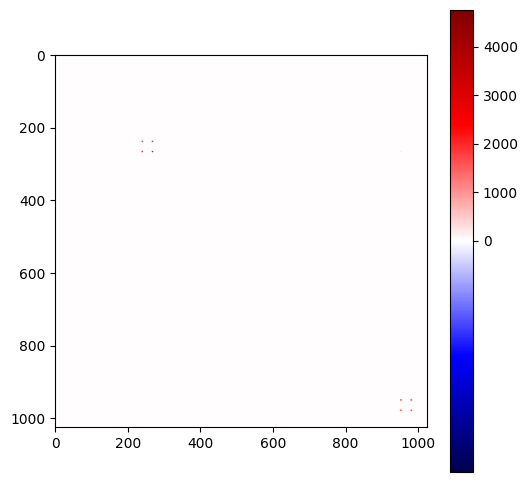

In [7]:
#There is some plotting pre-processing of the NMR spectrum that we are ignoring here, that is why
#we get a different plot that the one produced in the matlab script
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(vmin=-np.min(-np.real(spectrum)), vcenter=0, vmax=np.max(-np.real(spectrum)))

plt.figure(figsize=(6, 6))
plt.imshow(-np.real(spectrum), cmap='seismic',norm=norm)
plt.colorbar()
plt.show()